__Сергеенкова Лилия__

In [1]:
from knn import KNNClassifier
from knn.distances import euclidean_distance, cosine_distance
from knn.model_selection import knn_cross_val_score
from knn import BatchedKNNClassifier

In [2]:
from sklearn import datasets
images, labels = datasets.fetch_openml('mnist_784', version=1, cache=True, return_X_y=True)

In [3]:
# обучающая и тестовая выборки
X_train = images[:60000, :]
y_train = labels[:60000]

X_test = images[-10000:, :]
y_test = labels[-10000:]

In [4]:
# исследование алгоритмов поиска ближайших соседей для разного числа признаков (задание №1)
import numpy as np
import pandas as pd
import time

alg = ['my_own', 'brute', 'kd_tree', 'ball_tree']

# создаем случайные множества индексов признаков
n = X_train.shape[1]
ind_1 = np.random.choice(n, 10, replace=False)
ind_2 = np.random.choice(n, 20, replace=False)
ind_3 = np.random.choice(n, 100, replace=False)

X_train_1 = X_train[:, ind_1]
X_test_1 = X_test[:, ind_1]

X_train_2 = X_train[:, ind_2]
X_test_2 = X_test[:, ind_2]

X_train_3 = X_train[:, ind_3]
X_test_3 = X_test[:, ind_3]

# таблицы для результатов замера времени
df_fit = pd.DataFrame(columns=['10', '20', '100'])
df_predict = pd.DataFrame(columns=['10', '20', '100'])

for el in alg:
    t_f = []
    t_pr = []

    bclf = BatchedKNNClassifier(n_neighbors=5, algorithm=el, metric='euclidean', weights='uniform')
    bclf.set_batch_size(100)

    # 10 признаков
    start_time = time.time()
    bclf.fit(X_train_1, y_train)
    t_f.append(time.time() - start_time)
    
    start_time = time.time()
    y_pred = bclf.predict(X_test_1)
    t_pr.append(time.time() - start_time)
    
    # 20 признаков
    start_time = time.time()
    bclf.fit(X_train_2, y_train)
    t_f.append(time.time() - start_time)
    
    start_time = time.time()
    y_pred = bclf.predict(X_test_2)
    t_pr.append(time.time() - start_time)

    # 100 признаков
    start_time = time.time()
    bclf.fit(X_train_3, y_train)
    t_f.append(time.time() - start_time)
    
    start_time = time.time()
    y_pred = bclf.predict(X_test_3)
    t_pr.append(time.time() - start_time) 
    
    df_fit.loc[el] = t_f
    df_predict.loc[el] = t_pr

In [5]:
# визуализация исследования алгоритмов поиска ближайших соседей в различных ситуациях
print('Время работы fit:\n', df_fit)
print('==============================================\n')
print('Время работы predict:\n', df_predict)

Время работы fit:
                  10         20       100
my_own     0.000005   0.000007  0.000006
brute      0.000522   0.000932  0.003360
kd_tree    1.701743   9.311244  5.643761
ball_tree  1.878937  10.481175  6.174580

Время работы predict:
                   10         20         100
my_own     17.211008  15.603473   19.787645
brute      14.548391  13.103747   16.189664
kd_tree     1.219227   6.590796  111.369672
ball_tree  10.280405  21.630857  124.591713


__Анализ результатов:__

Метод fit состоит в простом запоминании объектов выборки. Для того чтобы хранение и поиск были эффективными, заводят специальные структуры, такие как kd-tree и ball-tree. Но соответственно для них fit становится дольше ввиду затраты время на создание структуры и записи данных в нее. Ball-tree лучше справляется с признаковым пространством большой размерности ввиду своей геометрии (шары более точно оценивают нижнюю границу для расстояния до точек), в то время как в kd-tree все объекты становятся одинаково далекими друг от друга.

Анализируя таблицу, видно, что лучший результат по времени у predict у алгоритма brute, его и будем использовать в дальнейшем. Очень близко идет собственная реализация алгоритма. Для деревьев же скорость роста очень большая ввиду "проклятия размерности".

In [6]:
# кросс-валидация (задания №2-3)
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

#точности алгоритмов 
accuracy_alg = []

#времена работы алгоритмов 
time_alg = []

k_list = range(1, 11)
cv = KFold(n_splits=3)

# algorithm='brute', metric='euclidean', weights='uniform'
start_time = time.time()
ac = knn_cross_val_score(X_train, y_train, k_list, scoring="accuracy", cv=None, algorithm='brute', metric='euclidean', weights='uniform')
time_alg.append((time.time() - start_time)/len(k_list))

# записываем среднее значение точности на каждом k при кросс-валидации
acc = []
for el in list(ac.values()):
    acc.append(np.mean(el))
accuracy_alg.append(acc)

# algorithm='brute', metric='cosine', weights='uniform'
start_time = time.time()
ac = knn_cross_val_score(X_train, y_train, k_list, scoring="accuracy", cv=None, algorithm='brute', metric='cosine', weights='uniform')
time_alg.append((time.time() - start_time)/len(k_list))

# записываем среднее значение точности на каждом k при кросс-валидации
acc = []
for el in list(ac.values()):
    acc.append(np.mean(el))
accuracy_alg.append(acc)

# algorithm='brute', metric='euclidean', weights='distance'
start_time = time.time()
ac = knn_cross_val_score(X_train, y_train, k_list, scoring="accuracy", cv=None, algorithm='brute', metric='euclidean', weights='distance')
time_alg.append((time.time() - start_time)/len(k_list))

# записываем среднее значение точности на каждом k при кросс-валидации
acc = []
for el in list(ac.values()):
    acc.append(np.mean(el))
accuracy_alg.append(acc)

# algorithm='brute', metric='cosine', weights='distance'
start_time = time.time()
ac = knn_cross_val_score(X_train, y_train, k_list, scoring="accuracy", cv=None, algorithm='brute', metric='cosine', weights='distance')
time_alg.append((time.time() - start_time)/len(k_list))

# записываем среднее значение точности на каждом k при кросс-валидации
acc = []
for el in list(ac.values()):
    acc.append(np.mean(el))
accuracy_alg.append(acc)

In [7]:
# время работы алгоритмов для разных k
# для каждого k время работы примерно одинаково ввиду реализации, 
# так что среднее время работы на одном k в 10 раз меньше, потому что всего мы обсчитываем 10 значений k

df_time = pd.DataFrame(columns=['Время работы'])

df_time.loc['Алгоритм без весов с евклидовой метрикой'] = time_alg[0]
df_time.loc['Алгоритм без весов с косинусной метрикой'] = time_alg[1]
df_time.loc['Алгоритм с весами с евклидовой метрикой'] = time_alg[2]
df_time.loc['Алгоритм с весами с косинусной метрикой'] = time_alg[3]
print(df_time)

                                          Время работы
Алгоритм без весов с евклидовой метрикой     20.393497
Алгоритм без весов с косинусной метрикой     40.700157
Алгоритм с весами с евклидовой метрикой      20.718276
Алгоритм с весами с косинусной метрикой      40.539187


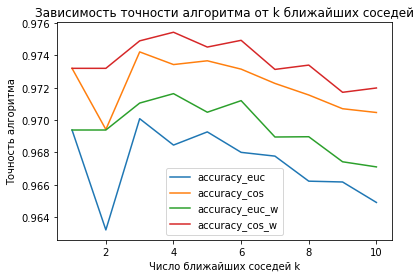

In [17]:
#график зависимости точности от числа соседей для всех вариаций алгоритма 'brute'
import matplotlib.pyplot as plt
x = range(1, 11)

plt.plot(x, accuracy_alg[0], label = 'accuracy_euc')
plt.plot(x, accuracy_alg[1], label = 'accuracy_cos')
plt.plot(x, accuracy_alg[2], label = 'accuracy_euc_w')
plt.plot(x, accuracy_alg[3], label = 'accuracy_cos_w')
plt.title('Зависимость точности алгоритма от k ближайших соседей')
plt.xlabel('Число ближайших соседей k')
plt.ylabel('Точность алгоритма')
plt.legend(shadow = False,fontsize = 10)
plt.show()

__Анализ результатов:__

Из таблицы для времен работы алгоритмов, во-первых, видно, что время работы алгоритма с весами и без для одной и той же метрики почти одинаковые, ведь выполняются практически одни и те же вычисления при работе алгоритмов. 

Во-вторых, время работы алгоритма с косинусной метрикой больше, нежели чем с евклидовой, так как производится больше арифметических операций, но однако точность с этой метрикой выше. В косинусной метрике производится расчет угла между векторами, таким образом, не учитывается вес векторов, то есть, данная метрика нечувствительна к масштабу признаков, в то время как евклидова очень чувствительна к масштабу признаков.  

При больших k точность алгоритма падает, ведь он становится слишком устойчивым и в конечном счете вырождается в константу, так что необходимо выбирать некоторое промежуточное оптимальное значение k. При малых k алгоритм будет крайне неустойчивым к выбросам. Также видно, что алгоритм с весами работает лучше, объекты, расположенные ближе к рассматриваемому имеют большее значение, нежели чем далекие. 

На основе анализа результатов этого пункта возьмем алгоритм с наибольшей точностью: с косинусной мерой и числом соседей $k=4$. 

In [9]:
# задание № 4: применение лучшего алгоритма (взвешенный 'brute' с косинусной метрикой с числом соседей k=4)
bclf = BatchedKNNClassifier(n_neighbors=4, algorithm='brute', metric='cosine', weights='distance')
bclf.set_batch_size(100)
bclf.fit(X_train, y_train)
y_pred = bclf.predict(X_test)
ac = accuracy_score(y_test, y_pred)

In [10]:
print('Полученная точность алгоритма: ', ac)
print('Точность алгоритма на кросс-валидации: ', accuracy_alg[3][3])

Полученная точность алгоритма:  0.9752
Точность алгоритма на кросс-валидации:  0.9754333333333334


__Анализ результатов:__

Точность получилась примерно такой же, как на кросс-валидации. Следовательно, кросс-валидация корректно дает оценку на точность алгоритма.

In [11]:
print('TEST ERROR RATE: ', round((1 - ac)*100,2), '%')

TEST ERROR RATE:  2.48 %


__Анализ результатов:__

Данная реализация алгоритма k-ближайших соседей показала результат лучше, чем результаты алгоритмов в таблице без предобработки данных.

In [12]:
# построение матрицы ошибок
from sklearn.metrics import confusion_matrix
labels = range(0, 10)
con_mat = confusion_matrix(y_test, y_pred)
con_mat

array([[ 977,    1,    0,    0,    0,    0,    1,    1,    0,    0],
       [   0, 1129,    3,    1,    0,    0,    2,    0,    0,    0],
       [   8,    0, 1009,    1,    1,    0,    0,    8,    5,    0],
       [   0,    1,    3,  976,    1,   12,    0,    4,    9,    4],
       [   2,    1,    0,    0,  946,    0,    6,    2,    0,   25],
       [   4,    0,    0,    9,    1,  863,    7,    1,    4,    3],
       [   3,    3,    0,    0,    1,    3,  948,    0,    0,    0],
       [   2,   10,    4,    0,    1,    0,    0,  998,    0,   13],
       [   7,    1,    2,    9,    3,    3,    5,    4,  936,    4],
       [   7,    7,    2,    5,    7,    3,    1,    4,    3,  970]])

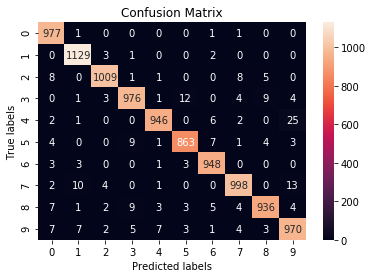

In [13]:
# визуализация матрицы ошибок
import seaborn as sns
import matplotlib.pyplot as plt     

ax = plt.subplot()
sns.heatmap(con_mat, annot=True, ax = ax, fmt='g')

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(np.arange(0, con_mat.shape[0]))
ax.yaxis.set_ticklabels(np.arange(0, con_mat.shape[0]))

plt.show()

__Анализ результатов:__

Согласно определению матрицы ошибок: ее элемент $C[i,j]$ равен количеству объектов, которые относятся к классу $i$, но были отнесены к классу $j$. Таким образом, на диагонали матрицы стоят числа, равные количеству правильных отнесений к каждому из классов. 

Анализируя таблицу, можно сделать вывод, что наибольшее число ошибок было совершено в классах: 3 (12 объектов было отнесено к классу 5, 9 - к классу 8; 4 (25 объектов отнесено к классу 9); 7 (10 объектов отнесено к классу 1, 13 - к классу 9)

In [14]:
#визуализация ошибочных объектов тестовой выборки

# ошибки в классе 3
ind_test = np.where(y_test == '3')
ind_pred = np.where(y_pred == '5')
ind_er_5 = np.intersect1d(ind_test, ind_pred)
print('Индексы объектов, на которых была совершена ошибка: относятся к 3 классу, но были отнесены к 5:\n', ind_er_5)

ind_test = np.where(y_test == '3')
ind_pred = np.where(y_pred == '8')
ind_er_8 = np.intersect1d(ind_test, ind_pred)
print('Индексы объектов, на которых была совершена ошибка: относятся к 3 классу, но были отнесены к 8:\n', ind_er_8)

Индексы объектов, на которых была совершена ошибка: относятся к 3 классу, но были отнесены к 5:
 [ 938  957 1290 2408 2952 2953 4740 6011 6045 6059 8277 8290]
Индексы объектов, на которых была совершена ошибка: относятся к 3 классу, но были отнесены к 8:
 [1114 2105 3549 4785 4990 5955 5973 6023 9944]


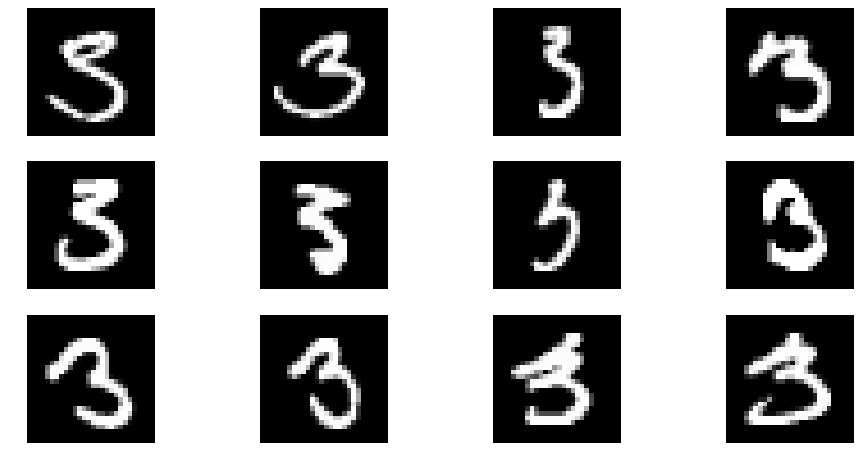

In [15]:
# выведем объекты, на которых были совершены ошибки

# объекты, на которых ошибки: относятся к 3 классу, но были отнесены к 5
X_test_er_5 = X_test[ind_er_5]
fig, axs = plt.subplots(3, 4, figsize=(16, 8))
axs = axs.ravel()

for i in range(X_test_er_5.shape[0]):
    pixels = X_test_er_5[i, :].reshape((28, 28))
    axs[i].imshow(pixels, cmap='gray')
    axs[i].axis('off')
plt.show()

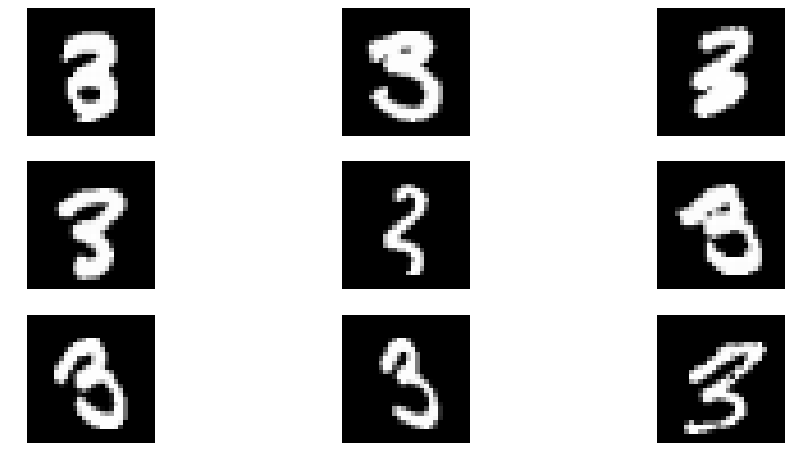

In [16]:
# выведем объекты, на которых были совершены ошибки

# объекты, на которых ошибки: относятся к 3 классу, но были отнесены к 8
X_test_er_8 = X_test[ind_er_8]
fig, axs = plt.subplots(3, 3, figsize=(16, 8))
axs = axs.ravel()

for i in range(X_test_er_8.shape[0]):
    pixels = X_test_er_8[i, :].reshape((28, 28))
    axs[i].imshow(pixels, cmap='gray')
    axs[i].axis('off')
plt.show()

__Анализ результатов:__

Действительно, можно заметить, что, например, объекты, ошибочно отнесенные к 5 классу, имеют черты, похожие на 5: палочка сверху слишком спрямленная для 3 или, наоборот, почти отсутствие сверху какого-либо закругления, что также приводит к ошибочному результату. 

Во втором случае ситуация аналогичная: скругления у 3 практически замыкаются или, наоборот, слишком маленькие, что приводит к тому, что объекты приобретают черты класса 8.